In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

DATA_FILE = '/home/mitchell/cgp/CGPExperiments/build/imageGeneData.csv'

In [2]:
df = pd.read_csv(DATA_FILE, sep='|')
print(df.shape)
df.head()

(40000, 4)


,geneName,iterationNum,runtime,params
0,threshold,0,271,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
1,threshold,1,354,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
2,threshold,2,316,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
3,threshold,3,287,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
4,threshold,4,285,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."


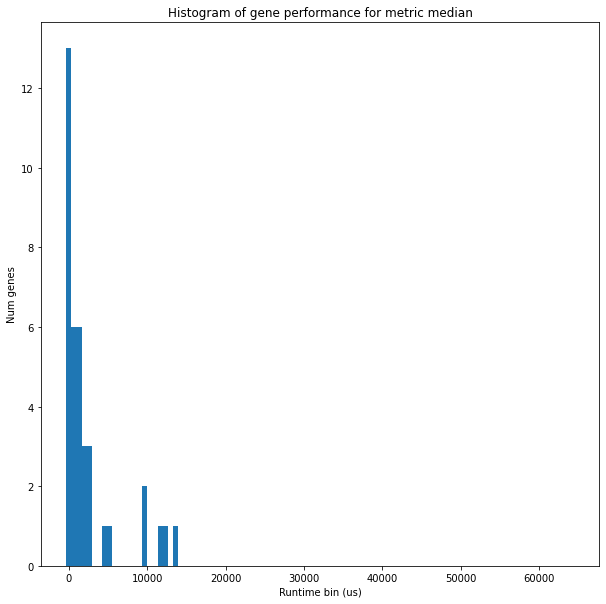

In [3]:
def compute_metric(series, metric_name):
    metric_name = metric_name.lower()
    if (metric_name == 'max'):
        return np.max(series)
    elif (metric_name == 'min'):
        return np.min(series)
    elif ((metric_name == 'mean') or (metric_name == 'avg')):
        return np.mean(series)
    elif (metric_name == 'p95'):
        return np.percentile(series, 95)
    elif (metric_name == 'p99'):
        return np.percentile(series, 99)
    elif (metric_name == 'median'):
        return np.median(series)
    
    raise ValueError('Unknown metric: {0}'.format(metric_name))
    
def plot_perf_report(df, metric):
    genes = list(df['geneName'].unique())
    
    metric_values = {}
    max_metric_value = -1
    for gene in genes:
        filtered = df[df['geneName'] == gene]
        metric_value = compute_metric(filtered['runtime'], metric)
        max_metric_value = max(max_metric_value, metric_value)
        metric_values[gene] = metric_value
    
    step = max_metric_value / 100
    b = np.arange(0, max_metric_value, step)
    m = [metric_values[k] for k in metric_values]
    hist, bb = np.histogram(m, bins=b)
    hist = list(hist) + [0]
    
    fig = plt.figure(figsize=(10,10))
    plt.bar(bb, list(hist), width=max_metric_value / 100)
    plt.xlabel('Runtime bin (us)')
    plt.ylabel('Num genes')
    
    plt.title('Histogram of gene performance for metric {0}'.format(metric))
    
    plt.show()
    
plot_perf_report(df, 'median')

In [4]:
def print_long_times(df, metric, thresh):
    genes = list(df['geneName'].unique())
    
    metric_values = {}
    for gene in genes:
        filtered = df[df['geneName'] == gene]
        metric_value = compute_metric(filtered['runtime'], metric)
        if (metric_value >= thresh):
            metric_values[gene] = metric_value
            
    metric_values = [(k,metric_values[k]) for k in metric_values]
    metric_values.sort(reverse=True, key=lambda x: x[1])
    
    print('Genes with {0} runtime >= {1}:'.format(metric, thresh))
    for metric_value in metric_values:
        print('\t{0}: {1} us'.format(metric_value[0], metric_value[1]))
        
print_long_times(df, 'median', 6000)

Genes with median runtime >= 6000:
	smoothMedian: 64728.5 us
	smoothBilateral: 64506.0 us
	localNormalize: 14172.5 us
	sobelX: 12567.5 us
	sobel: 11842.0 us
	sobelY: 10278.5 us
	exp: 10143.0 us


In [5]:
def print_gene_runtimes_by_parameters(df, gene, gene_parameter, metric):
    filtered = df[df['geneName'] == gene].copy()
    filtered['value_of_interest'] = filtered.apply( \
        lambda r: float(json.loads(r['params'])[gene_parameter]), axis=1)
    
    unique_values = list(filtered['value_of_interest'].unique())
    unique_values.sort()
    print('Runtime {0} sliced by {1}:'.format(metric, gene_parameter))
    for unique_value in unique_values:
        param_data_points = filtered[filtered['value_of_interest'] == unique_value]
        metric_value = compute_metric(param_data_points['runtime'], metric)
        print('\t{0}: {1}'.format(unique_value, metric_value))
    
    print()
    
print_gene_runtimes_by_parameters(df, 'smoothMedian', 'kernelSize', 'median')
print_gene_runtimes_by_parameters(df, 'smoothBilateral', 'd', 'median')
print_gene_runtimes_by_parameters(df, 'smoothBilateral', 'sigma', 'median')

Runtime median sliced by kernelSize:
	3.0: 823.0
	5.0: 5246.5
	7.0: 56734.0
	9.0: 64727.0
	11.0: 74116.5
	13.0: 83995.5
	15.0: 92649.5

Runtime median sliced by d:
	3.0: 18729.0
	4.0: 48288.0
	5.0: 48246.5
	6.0: 43934.0
	7.0: 43886.0
	9.0: 73273.0
	10.0: 118757.5
	13.0: 163887.5
	14.0: 217610.0
	16.0: 287914.0

Runtime median sliced by sigma:
	0.786787: 64506.0



In [6]:
def generate_gene_summary(df, metric, output_filename):
    with open(output_filename, 'w') as f:
        f.write('gene,runtime\n')
        genes = list(df['geneName'].unique())
        genes.sort()
        
        for gene in genes:
            filtered = df[df['geneName'] == gene]
            metric_value = compute_metric(filtered['runtime'], metric)
            f.write('{0},{1}\n'.format(gene, metric_value))
            
generate_gene_summary(df, 'median', 'summary.csv')